In [1]:
import lasagne
import nolearn
import theano
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import tarfile
from scipy import ndimage
from PIL import Image
import cv2
import matplotlib.image as mpimg
import tarfile
from six.moves import cPickle as pickle
import time
import logging
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Conv2DLayer
from lasagne.layers import MaxPool2DLayer
from lasagne.updates import adam
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import TrainSplit

from nolearn.lasagne import objective

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


In [2]:
#set higher internal recursive limit to prevent cpickle from crashing on big datasets 
sys.setrecursionlimit(50000)

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("Started notebook")

In [4]:
%matplotlib inline

In [5]:
train_folders = sorted(map(lambda x: os.path.join('../dataset', x), os.listdir('../dataset/')), key=lambda x:int(x.split('/')[-1]))
test_folders = sorted(map(lambda x: os.path.join('../testset', x), os.listdir('../testset/')), key=lambda x:int(x.split('/')[-1]))

In [6]:
image_size = 50
pixel_depth = 255
def load_data(data_folders, min_num_images, max_num_images):
  dataset = np.ndarray(
    shape=(max_num_images, image_size, image_size), dtype = np.float32)
  labels = np.ndarray(shape=(max_num_images), dtype=np.int32)
  label_index = 0
  image_index = 0
  for folder in data_folders:
    print folder
    for image in os.listdir(folder):
      if image_index >= max_num_images:
        raise Exception('More images than expercted %d >= %d' % 
                        (image_index, max_num_images))
      image_file = os.path.join(folder, image)
      try:
        image_data = (ndimage.imread(image_file)[:,:,0].astype(float) - pixel_depth/2)/pixel_depth
        if image_data.shape != (image_size, image_size):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[image_index, :, :] = image_data
        labels[image_index] = label_index
        image_index += 1
      except IOError as e:
        print('Could not read:', image_file, ':', e, '-it\s ok, skipping')
    label_index += 1
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  labels = labels[0:num_images]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' % (
            num_images, min_num_images))
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  print('Labels:', labels.shape)
  return dataset, labels


In [7]:
train_dataset, train_labels = load_data(train_folders, 10000, 1400000)
test_dataset, test_labels = load_data(test_folders, 1800, 50000)

../dataset/0
../dataset/1
../dataset/2
../dataset/3
../dataset/4
../dataset/5
../dataset/6
../dataset/7
../dataset/8
../dataset/9
../dataset/10
../dataset/11
../dataset/12
../dataset/13
../dataset/14
../dataset/15
../dataset/16
../dataset/17
../dataset/18
../dataset/19
../dataset/20
../dataset/21
../dataset/22
../dataset/23
../dataset/24
../dataset/25
../dataset/26
../dataset/27
../dataset/28
../dataset/29
../dataset/30
../dataset/31
../dataset/32
../dataset/33
../dataset/34
../dataset/35
../dataset/36
../dataset/37
../dataset/38
../dataset/39
../dataset/40
('Full dataset tensor:', (615000, 50, 50))
('Mean:', 0.22578962)
('Standard deviation:', 0.17345642)
('Labels:', (615000,))
../testset/0
../testset/1
../testset/2
../testset/3
../testset/4
../testset/5
../testset/6
../testset/7
../testset/8
../testset/9
../testset/10
../testset/11
../testset/12
../testset/13
../testset/14
../testset/15
../testset/16
../testset/17
../testset/18
../testset/19
../testset/20
../testset/21
../testset/22


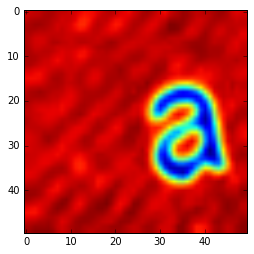

In [8]:
plt.imshow(train_dataset[0])

In [9]:
np.random.seed(133)
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

In [10]:
train_size = 200000
valid_size = 10000

valid_dataset = train_dataset[:valid_size,:,:]
valid_labels = train_labels[:valid_size]
train_dataset = train_dataset[valid_size:valid_size+train_size,:,:]
train_labels = train_labels[valid_size:valid_size+train_size]
print('Training', train_dataset.shape, train_labels.shape)
print('Validation', valid_dataset.shape, valid_labels.shape)

('Training', (200000, 50, 50), (200000,))
('Validation', (10000, 50, 50), (10000,))


In [11]:
X_train, y_train, X_valid, y_valid = train_dataset, train_labels, valid_dataset, valid_labels
X_test, y_test = test_dataset, test_labels

In [12]:
pickle_file = 'arialMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [ ]:
def load_dataset():
    pickle_file = 'arialMNIST.pickle'

    with open(pickle_file, 'rb') as f:
          save = pickle.load(f)
          train_dataset = save['train_dataset']
          train_labels = save['train_labels']
          valid_dataset = save['valid_dataset']
          valid_labels = save['valid_labels']
          test_dataset = save['test_dataset']
          test_labels = save['test_labels']
          del save  # hint to help gc free up memory
          print('Training set', train_dataset.shape, train_labels.shape)
          print('Validation set', valid_dataset.shape, valid_labels.shape)
          #print('Test set', test_dataset.shape, test_labels.shape)
          return train_dataset, train_labels, valid_dataset, valid_labels

In [ ]:
X_train, y_train, X_valid, y_valid = load_dataset()

In [13]:
N_CLASSES = len(os.listdir('../dataset/'))

In [14]:
def build_mlp(input_var=None):
    # This creates an MLP of two hidden layers of 800 units each, followed by
    # a softmax output layer of 10 units. It applies 20% dropout to the input
    # data and 50% dropout to the hidden layers.

    # Input layer, specifying the expected input shape of the network
    # (unspecified batchsize, 1 channel, 50 rows and 50 columns) and
    # linking it to the given Theano variable `input_var`, if any:
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 50, 50),
                                     input_var=input_var)

    # Apply 20% dropout to the input data:
    l_in_drop = lasagne.layers.DropoutLayer(l_in, p=0.2)

    # Add a fully-connected layer of 800 units, using the linear rectifier, and
    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.DenseLayer(
            l_in_drop, num_units=800,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.Orthogonal(gain='relu')
    )

    # We'll now add dropout of 50%:
    l_hid1_drop = lasagne.layers.DropoutLayer(l_hid1, p=0.5)

    # Another 800-unit layer:
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1_drop, num_units=800,
            nonlinearity=lasagne.nonlinearities.rectify)

    # 50% dropout again:
    l_hid2_drop = lasagne.layers.DropoutLayer(l_hid2, p=0.5)

    # Finally, we'll add the fully-connected output layer, of 10 softmax units:
    l_out = lasagne.layers.DenseLayer(
            l_hid2_drop, num_units=51,
            nonlinearity=lasagne.nonlinearities.softmax)

    # Each layer is linked to its incoming layer(s), so we only need to pass
    # the output layer to give access to a network in Lasagne:
    return l_out

In [15]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]


In [16]:
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

In [17]:
#defining nessecary functions
network = build_mlp(input_var)
# prediction = lasagne.layers.get_output(model)
# loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
# loss = loss.mean()
# params = lasagne.layers.get_all_params(model, trainable=True)
# updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.01, momentum=0.9)
# test_prediction = lasagne.layers.get_output(model, deterministic=True)
# test_loss = lasagne.objectives.categorical_crossentropy(test_prediction, target_var)
# test_loss = test_loss.mean()
# test_acc = T.mean(T.eq(T.argmax(test_prediction,axis=1),target_var),dtype=theano.config.floatX)
# train_fn = theano.function([input_var, target_var], loss, updates=updates)
# val_fn = theano.function([input_var, target_var], [test_loss, test_acc])


# Create a loss expression for training, i.e., a scalar objective we want
# to minimize (for our multi-class problem, it is the cross-entropy loss):
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()
# We could add some weight decay as well here, see lasagne.regularization.

# Create update expressions for training, i.e., how to modify the
# parameters at each training step. Here, we'll use Stochastic Gradient
# Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
params = lasagne.layers.get_all_params(network, trainable=True)
nesterov_updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.01, momentum=0.9)

# Create a loss expression for validation/testing. The crucial difference
# here is that we do a deterministic forward pass through the network,
# disabling dropout layers.
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
# As a bonus, also create an expression for the classification accuracy:
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

# Compile a function performing a training step on a mini-batch (by giving
# the updates dictionary) and returning the corresponding training loss:
train_fn = theano.function([input_var, target_var], loss, updates=nesterov_updates)

# Compile a second function computing the validation loss and accuracy:
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])


In [18]:
X_train = X_train.reshape(X_train.shape[0],1, 50, 50)
X_valid = X_valid.reshape(X_valid.shape[0],1, 50, 50)
X_test = X_test.reshape(X_test.shape[0], 1, 50, 50)

In [19]:
def main(num_epochs=500):
    for epoch in range(num_epochs):
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches+=1

        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_valid, y_valid, 500, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))
        
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 500, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        test_err += err
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    print("  test accuracy:\t\t{:.2f} %".format(
        test_acc / test_batches * 100))    

In [20]:
main()

Epoch 1 of 500 took 2.126s
  training loss:		3.119336
  validation loss:		2.256187
  validation accuracy:		39.65 %
Epoch 2 of 500 took 2.145s
  training loss:		2.184483
  validation loss:		1.520592
  validation accuracy:		58.16 %
Epoch 3 of 500 took 2.088s
  training loss:		1.639953
  validation loss:		1.034931
  validation accuracy:		71.42 %
Epoch 4 of 500 took 2.167s
  training loss:		1.269015
  validation loss:		0.745923
  validation accuracy:		79.06 %
Epoch 5 of 500 took 2.152s
  training loss:		1.037571
  validation loss:		0.594935
  validation accuracy:		82.34 %
Epoch 6 of 500 took 2.123s
  training loss:		0.882527
  validation loss:		0.494782
  validation accuracy:		84.91 %
Epoch 7 of 500 took 2.180s
  training loss:		0.784426
  validation loss:		0.429900
  validation accuracy:		85.95 %
Epoch 8 of 500 took 2.191s
  training loss:		0.702831
  validation loss:		0.383790
  validation accuracy:		87.38 %
Epoch 9 of 500 took 2.152s
  training loss:		0.644661
  validation loss:		0.3449

In [ ]:
prediction_fn = T.argmax(test_prediction, axis=1)
predict = theano.function([input_var], [prediction_fn])

In [ ]:
plt.imshow(X_test[0].reshape(50,50))

In [ ]:
y_test

In [ ]:
predicted_values = predict(X_test)

In [ ]:
misclassified = [y_test[index] for index in range(len(y_test)) if y_test[index] != predicted_values[0][index]]

In [ ]:
from collections import Counter
from string import ascii_lowercase

In [ ]:
letter_string = ascii_lowercase + ' ' + '-' + '_' + ''.join(map(str, range(0, 11)))

In [ ]:
counted = Counter(misclassified)

In [ ]:
correct_counted = Counter(y_test)

In [ ]:
[letter_string[position] for position in zip(*counted.most_common(13))[0]]

In [ ]:
plt.bar(counted.keys(), counted.values())

In [21]:
# Optionally, you could now dump the network weights to a file like this:
def dump(model, name):
    np.savez(name+'.npz', *lasagne.layers.get_all_param_values(model))

# And load them again later on like this:
def load(model, name):
    with np.load(name + '.npz') as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(model, param_values)

In [22]:
dump(network, 'baseline9478%')

## Add more layers

### Didn't work :(((

In [27]:
def deep_mlp(input_var=None):
    # This creates an MLP of two hidden layers of 800 units each, followed by
    # a softmax output layer of 10 units. It applies 20% dropout to the input
    # data and 50% dropout to the hidden layers.

    # Input layer, specifying the expected input shape of the network
    # (unspecified batchsize, 1 channel, 50 rows and 50 columns) and
    # linking it to the given Theano variable `input_var`, if any:
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 50, 50),
                                     input_var=input_var)

    # Apply 20% dropout to the input data:
    l_in_drop = lasagne.layers.DropoutLayer(l_in, p=0.2)

    # Add a fully-connected layer of 800 units, using the linear rectifier, and
    # initializing weights with Glorot's scheme (which is the default anyway):
    l_hid1 = lasagne.layers.DenseLayer(
            l_in_drop, num_units=800,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.Orthogonal(gain='relu'))

    # We'll now add dropout of 50%:
    l_hid1_drop = lasagne.layers.DropoutLayer(l_hid1, p=0.5)

    # Another 800-unit layer:
    l_hid2 = lasagne.layers.DenseLayer(
            l_hid1_drop, num_units=1024,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.Orthogonal(gain='relu')
    )

    # 50% dropout again:
    l_hid2_drop = lasagne.layers.DropoutLayer(l_hid2, p=0.5)

    # Finally, we'll add the fully-connected output layer, of 10 softmax units:

    l_hid3 = lasagne.layers.DenseLayer(
        l_hid2_drop,
        num_units=512,
        nonlinearity = lasagne.nonlinearities.rectify,
        W=lasagne.init.Orthogonal(gain='relu')
    )

    l_hid3_drop = lasagne.layers.DropoutLayer(l_hid3, p=0.5)

    l_hid4 = lasagne.layers.DenseLayer(
        l_hid3_drop,
        num_units = 256,
        nonlinearity = lasagne.nonlinearities.rectify,
        W = lasagne.init.Orthogonal(gain='relu')
    )

    l_hid4_drop = lasagne.layers.DropoutLayer(l_hid4, p=0.5)

    l_out = lasagne.layers.DenseLayer(
            l_hid4_drop, num_units=51,
            nonlinearity=lasagne.nonlinearities.softmax)

    # Each layer is linked to its incoming layer(s), so we only need to pass
    # the output layer to give access to a network in Lasagne:
    return l_out

In [28]:
network = deep_mlp(input_var)
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()
params = lasagne.layers.get_all_params(network, trainable=True)
nesterov_updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.01, momentum=0.9)

test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,                                                        target_var)
test_loss = test_loss.mean()
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

train_fn = theano.function([input_var, target_var], loss, updates=nesterov_updates)
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

In [29]:
###advanced testing in order to understand what's going on here

In [30]:
def deep_main(num_epochs=500):
    for epoch in range(num_epochs):
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches+=1

        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_valid, y_valid, 500, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))

In [31]:
deep_main()

Epoch 1 of 500 took 2.555s
  training loss:		3.670256
  validation loss:		3.051338
  validation accuracy:		13.23 %
Epoch 2 of 500 took 2.537s
  training loss:		2.897304
  validation loss:		2.400899
  validation accuracy:		24.11 %
Epoch 3 of 500 took 2.528s
  training loss:		2.521145
  validation loss:		2.117706
  validation accuracy:		32.29 %
Epoch 4 of 500 took 2.531s
  training loss:		2.281191
  validation loss:		1.834630
  validation accuracy:		41.26 %
Epoch 5 of 500 took 2.527s
  training loss:		2.052579
  validation loss:		1.572274
  validation accuracy:		49.26 %
Epoch 6 of 500 took 2.533s
  training loss:		1.835213
  validation loss:		1.315785
  validation accuracy:		57.08 %
Epoch 7 of 500 took 2.529s
  training loss:		1.648980
  validation loss:		1.085301
  validation accuracy:		65.16 %
Epoch 8 of 500 took 2.531s
  training loss:		1.493238
  validation loss:		0.970195
  validation accuracy:		68.86 %
Epoch 9 of 500 took 2.551s
  training loss:		1.370842
  validation loss:		0.8285

In [32]:
layers0 = [
    (InputLayer, {'shape':(None, 1, 50, 50)}),
    
    
    (Conv2DLayer, {'num_filters':96, 'filter_size':5}),
    (Conv2DLayer, {'num_filters':96, 'filter_size':3}),
    (Conv2DLayer, {'num_filters':96, 'filter_size':3}),
    (Conv2DLayer, {'num_filters':96, 'filter_size':3}),
    (Conv2DLayer, {'num_filters':96, 'filter_size':3}),
    (MaxPool2DLayer, {'pool_size':2}),
    
    (Conv2DLayer, {'num_filters':128, 'filter_size':3}),
    (Conv2DLayer, {'num_filters':128, 'filter_size':3}),
    (Conv2DLayer, {'num_filters':128, 'filter_size':3}),
    
    (DenseLayer, {'num_units':64}),
    (DropoutLayer, {}),
    (DenseLayer, {'num_units':64}),
    
    (DenseLayer, {'num_units':51, 'nonlinearity':lasagne.nonlinearities.softmax}),
]

In [33]:
def regularization_objective(layers, lambda1=0., lambda2=0., *args, **kwargs):
    losses = objective(layers, *args, **kwargs)
    weights = lasagne.layers.get_all_params(layers[-1], regularization_objective=True)
    sum_abs_weights = sum([abs(w).sum() for w in weights])
    # sum of squared weights for L2
    sum_squared_weights = sum([(w ** 2).sum() for w in weights])
    # add weights to regular loss
    losses += lambda1 * sum_abs_weights + lambda2 * sum_squared_weights
    return losses

In [34]:
net0 = NeuralNet(
    layers=layers0,
    max_epochs=10,
    update=adam,
    update_learning_rate=0.0002,
    objective=regularization_objective,
    objective_lambda2=0.0025,
    train_split=TrainSplit(eval_size=0.25),
    verbose=2,
)

In [35]:
net0.fit(X_train, y_train)

# Neural Network with 2132531 learnable parameters

## Layer information

name        size         total    cap.Y    cap.X    cov.Y    cov.X
----------  ---------  -------  -------  -------  -------  -------
input0      1x50x50       2500   100.00   100.00   100.00   100.00
conv2d1     96x46x46    203136   100.00   100.00    10.00    10.00
conv2d2     96x44x44    185856    42.86    42.86    14.00    14.00
conv2d3     96x42x42    169344    33.33    33.33    18.00    18.00
conv2d4     96x40x40    153600    27.27    27.27    22.00    22.00
conv2d5     96x38x38    138624    23.08    23.08    26.00    26.00
maxpool2d6  96x19x19     34656    23.08    23.08    26.00    26.00
conv2d7     128x17x17    36992    35.29    35.29    34.00    34.00
conv2d8     128x15x15    28800    28.57    28.57    42.00    42.00
conv2d9     128x13x13    21632    24.00    24.00    50.00    50.00
dense10     64              64   100.00   100.00   100.00   100.00
dropout11   64              64   100.00   100.00   100.

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f2e62636e10>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f2e62636cd0>,
     custom_scores=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 50, 50)}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': 5, 'num_filters': 96}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': 3, 'num_filters': 96}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'fil...layers.dense.DenseLayer'>, {'num_units': 51, 'nonlinearity': <function softmax at 0x7f2ea121e410>})],
     loss=None, max_epochs=10, more_params={},
     objective=<function regularization_objective at 0x7f2b171dfc08>,
     objective_lambda2=0.0025,
     objective_loss_function=<function categorical_crossentropy at 0x7f2ea0fdf7d0>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7f2b16461710>],
     on_tr

In [36]:
from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion

<module 'matplotlib.pyplot' from '/mnt/storage/grapefroot/lasagne_font/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

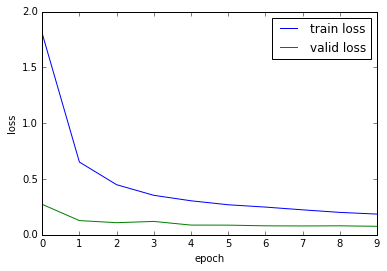

In [37]:
plot_loss(net0)

<module 'matplotlib.pyplot' from '/mnt/storage/grapefroot/lasagne_font/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

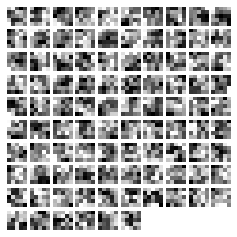

In [38]:
plot_conv_weights(net0.layers_[1], figsize=(4,4))

In [39]:
x = X_train[1:2]

<module 'matplotlib.pyplot' from '/mnt/storage/grapefroot/lasagne_font/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

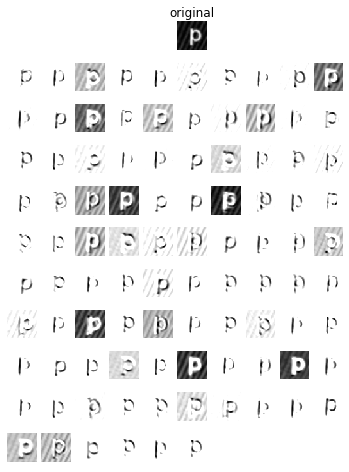

In [40]:
plot_conv_activity(net0.layers_[1],x)

<module 'matplotlib.pyplot' from '/mnt/storage/grapefroot/lasagne_font/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

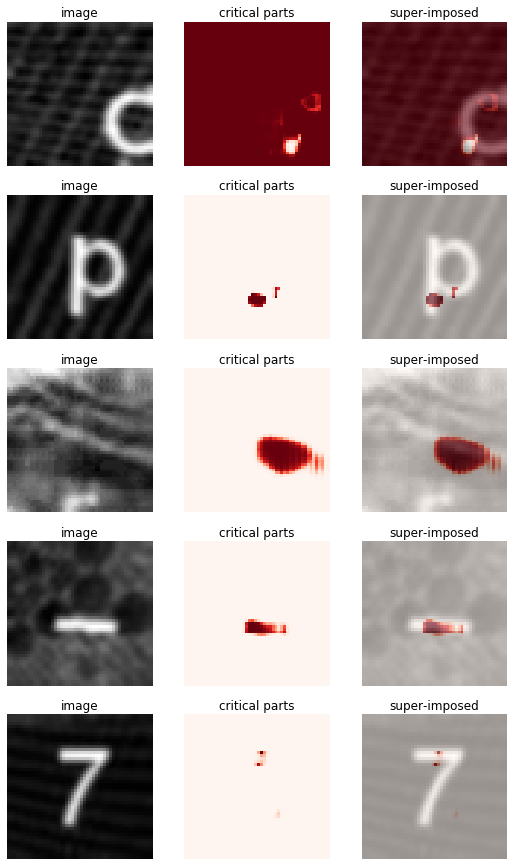

In [41]:
plot_occlusion(net0, X_train[:5], y_train[:5])

In [42]:
from nolearn.lasagne import PrintLayerInfo

In [43]:
layers4 = [
    (InputLayer, {'shape': (None, 1, 50, 50)}),

    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3), 'pad': 1}),
    (MaxPool2DLayer, {'pool_size': (2, 2)}),

    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3), 'pad': 1}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3), 'pad': 1}),
    (MaxPool2DLayer, {'pool_size': (2, 2)}),

    (DenseLayer, {'num_units': 64}),
    (DropoutLayer, {}),
    (DenseLayer, {'num_units': 64}),

    (DenseLayer, {'num_units': 51, 'nonlinearity': lasagne.nonlinearities.softmax}),
]



In [44]:
net4 = NeuralNet(
    layers=layers4,
    max_epochs = 30,
    update=adam,
    update_learning_rate=0.01,
    objective=regularization_objective,
    objective_lambda2=0.0025,
    train_split=TrainSplit(eval_size=0.25),
    verbose=2,
)

In [45]:
net4.initialize()

In [46]:
layer_info = PrintLayerInfo()

In [47]:
layer_info(net4)

# Neural Network with 745523 learnable parameters

## Layer information

name         size        total    cap.Y    cap.X    cov.Y    cov.X
-----------  --------  -------  -------  -------  -------  -------
input0       1x50x50      2500   100.00   100.00   100.00   100.00
conv2d1      32x50x50    80000   100.00   100.00     6.00     6.00
conv2d2      32x50x50    80000    60.00    60.00    10.00    10.00
conv2d3      32x50x50    80000    42.86    42.86    14.00    14.00
conv2d4      32x50x50    80000    33.33    33.33    18.00    18.00
conv2d5      32x50x50    80000    27.27    27.27    22.00    22.00
conv2d6      32x50x50    80000    23.08    23.08    26.00    26.00
conv2d7      32x50x50    80000    20.00    20.00    30.00    30.00
maxpool2d8   32x25x25    20000    20.00    20.00    30.00    30.00
conv2d9      64x25x25    40000    31.58    31.58    38.00    38.00
conv2d10     64x25x25    40000    26.09    26.09    46.00    46.00
conv2d11     64x25x25    40000    22.22    22.22    54.0

In [48]:
net4.fit(X_train, y_train)

# Neural Network with 745523 learnable parameters

## Layer information

name         size        total    cap.Y    cap.X    cov.Y    cov.X
-----------  --------  -------  -------  -------  -------  -------
input0       1x50x50      2500   100.00   100.00   100.00   100.00
conv2d1      32x50x50    80000   100.00   100.00     6.00     6.00
conv2d2      32x50x50    80000    60.00    60.00    10.00    10.00
conv2d3      32x50x50    80000    42.86    42.86    14.00    14.00
conv2d4      32x50x50    80000    33.33    33.33    18.00    18.00
conv2d5      32x50x50    80000    27.27    27.27    22.00    22.00
conv2d6      32x50x50    80000    23.08    23.08    26.00    26.00
conv2d7      32x50x50    80000    20.00    20.00    30.00    30.00
maxpool2d8   32x25x25    20000    20.00    20.00    30.00    30.00
conv2d9      64x25x25    40000    31.58    31.58    38.00    38.00
conv2d10     64x25x25    40000    26.09    26.09    46.00    46.00
conv2d11     64x25x25    40000    22.22    22.22    54.0

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f2e62636e10>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f2e62636cd0>,
     custom_scores=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 50, 50)}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': (3, 3), 'pad': 1, 'num_filters': 32}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': (3, 3), 'pad': 1, 'num_filters': 32}), (<class 'lasagne.la...layers.dense.DenseLayer'>, {'num_units': 51, 'nonlinearity': <function softmax at 0x7f2ea121e410>})],
     loss=None, max_epochs=30, more_params={},
     objective=<function regularization_objective at 0x7f2b171dfc08>,
     objective_lambda2=0.0025,
     objective_loss_function=<function categorical_crossentropy at 0x7f2ea0fdf7d0>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7f2b0a8d0050>],
     on_tr